Loading training data...
Found 8000 images belonging to 2 classes.
Loading testing data...
Found 2000 images belonging to 2 classes.
Training InceptionV3 model...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.8377 - loss: 0.3656 - val_accuracy: 0.9085 - val_loss: 0.2195
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.9368 - loss: 0.1535 - val_accuracy: 0.8995 - val_loss: 0.2613
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.9504 - loss: 0.1303 - val_accuracy: 0.9305 - val_loss: 0.1747
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9507 - loss: 0.1241 - val_accuracy: 0.9300 - val_loss: 0.1862
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9672 - loss: 0.0846 - val_accuracy: 0.9315 - val_loss: 0.1959
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9751 - loss: 0.0657 - val_accuracy: 0.9255 - val_loss: 0.2074
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/s

Model saved as inceptionv3_model_trained.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step
Training Accuracy: 0.99
Testing Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94      1000
     Class 1       0.95      0.92      0.93      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Confusion Matrix:
[[947  53]
 [ 76 924]]


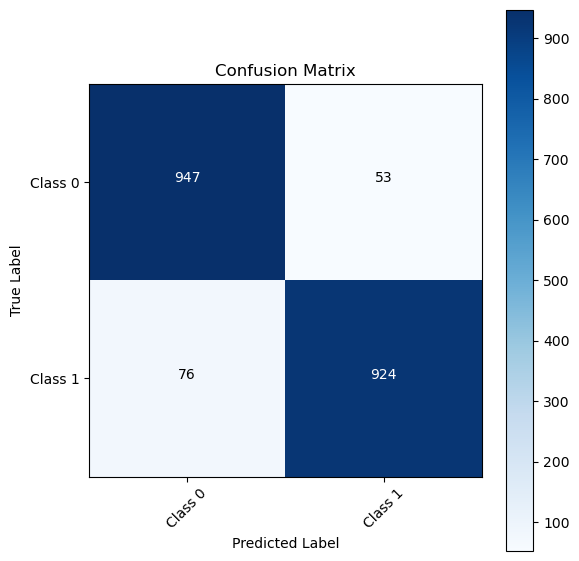

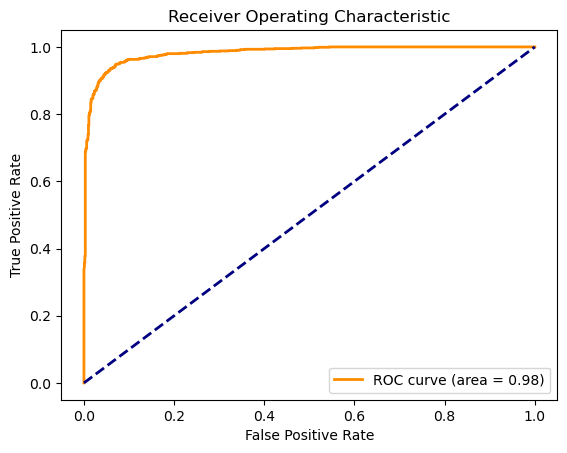

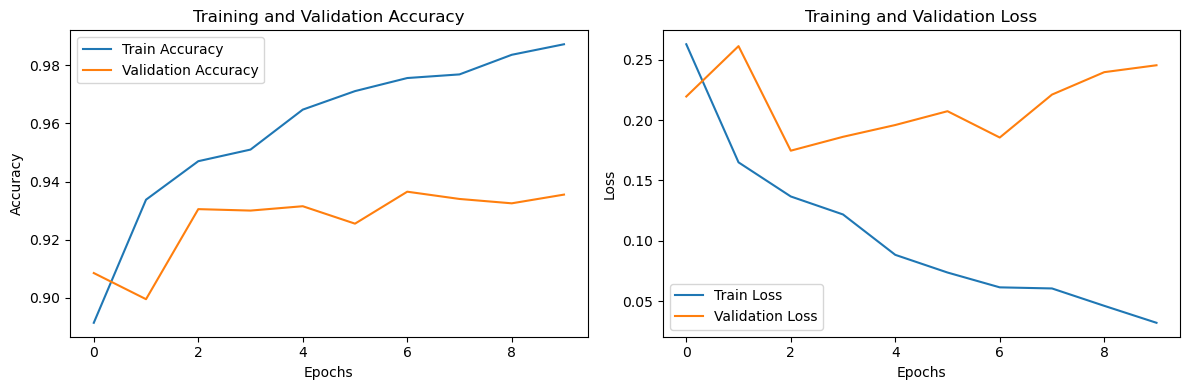

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from tensorflow.keras.models import load_model

# Paths to the dataset
train_dir = "C:/Users/server4/Desktop/train"
test_dir = "C:/Users/server4/Desktop/test"

# Parameters
img_size = (128, 128)  # Resize all images to 128x128
batch_size = 32
epochs = 10

# Load preprocessed data
def load_preprocessed_data(directory):
    datagen = ImageDataGenerator()  # No additional preprocessing
    generator = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False
    )
    images, labels = [], []
    for batch_images, batch_labels in generator:
        images.append(batch_images)
        labels.append(batch_labels)
        if len(images) * batch_size >= generator.samples:
            break
    return np.vstack(images), np.hstack(labels)

# Load train and test data
print("Loading training data...")
X_train, y_train = load_preprocessed_data(train_dir)
print("Loading testing data...")
X_test, y_test = load_preprocessed_data(test_dir)

# Normalize the data (scaling pixel values between 0 and 1)
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the classifier model on top of InceptionV3
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3 model
print("Training InceptionV3 model...")
history = model.fit(X_train_scaled, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_encoded))

# Save the trained model
model_filename = "inceptionv3_model_trained.h5"
model.save(model_filename)  # Save the entire model (weights, architecture, optimizer state, etc.)
print(f"Model saved as {model_filename}")

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert predictions to binary values
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Metrics
train_accuracy = accuracy_score(y_train_encoded, y_train_pred_binary)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_binary)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Classification report
print("Classification Report:")
class_names = ['Class 0', 'Class 1']  # Replace with actual class names
print(classification_report(y_test_encoded, y_test_pred_binary, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred_binary)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()

plot_confusion_matrix(cm, classes=class_names)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Loading the saved model for future use:
# model_loaded = load_model(model_filename)  # Uncomment this line to load the model
# model_loaded.predict(X_test_scaled)  # Example usage of the loaded model


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: AI-Generated


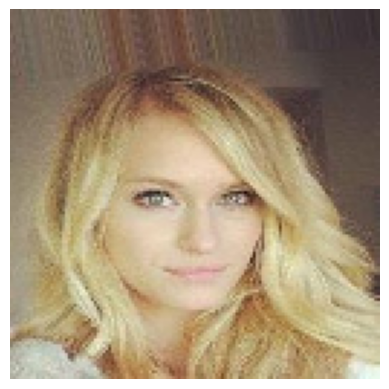

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the saved model
model_filename = "inceptionv3_model_trained.h5"

# Load the saved model
model = load_model(model_filename)

# Function to preprocess and predict on a single image
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(128, 128))  # Resize the image to match input size of the model

    # Convert the image to a numpy array and normalize
    img_array = image.img_to_array(img) / 255.0  # Normalize the pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to binary (0 for real, 1 for AI-generated)
    if prediction > 0.5:
        result = "AI-Generated"
    else:
        result = "Real"
    
    return result, img

# Path to the input image
input_image_path =r"C:\Users\server4\Desktop\test\real\005391_preprocessed.jpg" # Replace this with the path of the image you want to test
  # Replace this with the path of the image you want to test

# Predict on the input image
result, img = predict_image(input_image_path)

# Display the result and the image
print(f"Prediction: {result}")

# Show the image
plt.imshow(img)
plt.axis('off')
plt.show()


In [23]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io
import requests
from PIL import Image

# Load the trained model
model_filename = "inceptionv3_model_trained.h5"
model = load_model(model_filename)

# Function to preprocess and predict on a single image
def predict_image(img):
    # Check if the input is a URL, image file, or from webcam
    if isinstance(img, str):  # URL case
        img = Image.open(io.BytesIO(requests.get(img).content))
    elif isinstance(img, np.ndarray):  # Webcam or uploaded image case
        img = Image.fromarray(img)

    # Resize the image to match input size of the model
    img = img.resize((128, 128))

    # Convert the image to a numpy array and normalize
    img_array = np.array(img) / 255.0  # Normalize the pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to binary (0 for real, 1 for AI-generated)
    if prediction > 0.5:
        result = "AI-Generated"
    else:
        result = "Real"
    
    return img, result

# Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),  # Upload image
        gr.Textbox(type="text", label="Enter Image URL (optional)")  # URL input (optional)
    ],
    outputs=[gr.Image(type="pil", label="Predicted Image"), gr.Textbox(label="Prediction Result")],
    live=True
)

iface.launch()


C:\Users\server4\AppData\Roaming\Python\Python312\site-packages\gradio\utils.py:1003: UserWarning: Expected 1 arguments for function <function predict_image at 0x000002167928AFC0>, received 2.
  warnings.warn(
C:\Users\server4\AppData\Roaming\Python\Python312\site-packages\gradio\utils.py:1011: UserWarning: Expected maximum 1 arguments for function <function predict_image at 0x000002167928AFC0>, received 2.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [27]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io
import requests
from PIL import Image

# Load the trained model
model_filename = "inceptionv3_model_trained.h5"
model = load_model(model_filename)

# Function to preprocess and predict on a single image
def predict_image(img):
    # Check if the input is a URL, image file, or from webcam
    if isinstance(img, str):  # URL case
        img = Image.open(io.BytesIO(requests.get(img).content))
    elif isinstance(img, np.ndarray):  # Webcam or uploaded image case
        img = Image.fromarray(img)

    # Resize the image to match input size of the model
    img = img.resize((128, 128))

    # Convert the image to a numpy array and normalize
    img_array = np.array(img) / 255.0  # Normalize the pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to binary (0 for real, 1 for AI-generated)
    if prediction > 0.5:
        result = "AI-Generated"
    else:
        result = "Real"
    
    return img, result

# Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Upload Image"),  # Upload image
    outputs=[gr.Image(type="pil", label="Predicted Image"), gr.Textbox(label="Prediction Result")],
    live=True
)

iface.launch()




* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


Loading training data...
Found 8000 images belonging to 2 classes.
Loading testing data...
Found 2000 images belonging to 2 classes.


C:\Users\server4\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8963 - loss: 0.2604 - val_accuracy: 0.9960 - val_loss: 0.0116
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9955 - val_loss: 0.0136
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9976 - loss: 0.0074 - val_accuracy: 0.9935 - val_loss: 0.0148
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9915 - val_loss: 0.0241
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9973 - loss: 0.0085 - val_accuracy: 0.9980 - val_loss: 0.0031
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 1.0000 - loss: 1.4445e-04 - val_accuracy: 0.9970 - val_loss: 0.0033
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 1.0000 - loss: 6.2607e-05 - val_accuracy: 0.9990 - val_loss: 0.0027
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 1.0000 - loss: 3

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1000
     Class 1       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[1000    0]
 [   5  995]]


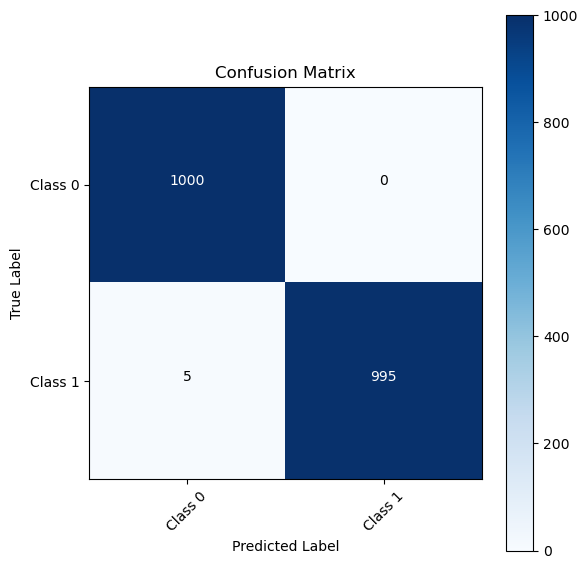

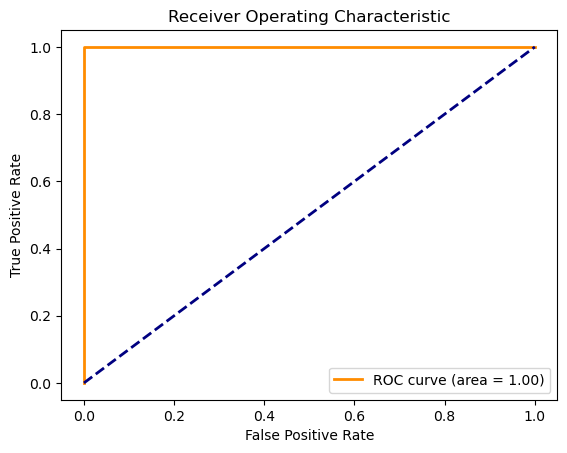

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

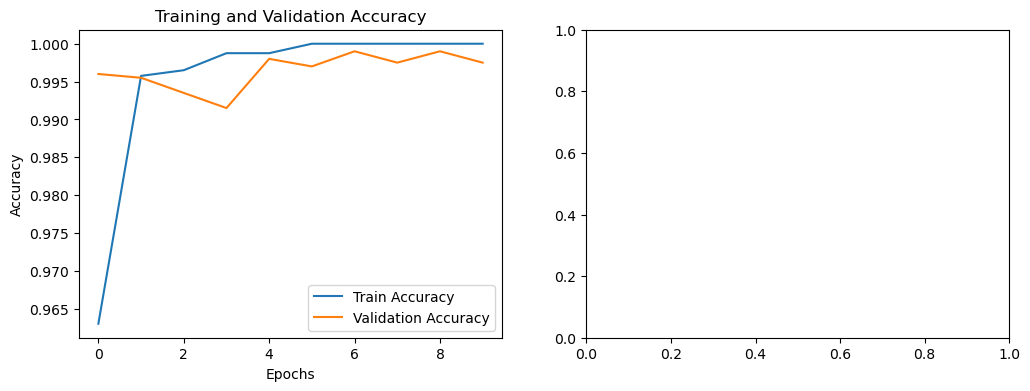

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

# Paths to the dataset
train_dir = "C:/Users/server4/Desktop/train"
test_dir = "C:/Users/server4/Desktop/test"

# Parameters
img_size = (128, 128)  # Resize all images to 128x128
batch_size = 32
epochs = 10

# Load preprocessed data
def load_preprocessed_data(directory):
    datagen = ImageDataGenerator()  # No additional preprocessing
    generator = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False
    )
    images, labels = [], []
    for batch_images, batch_labels in generator:
        images.append(batch_images)
        labels.append(batch_labels)
        if len(images) * batch_size >= generator.samples:
            break
    return np.vstack(images), np.hstack(labels)

# Load train and test data
print("Loading training data...")
X_train, y_train = load_preprocessed_data(train_dir)
print("Loading testing data...")
X_test, y_test = load_preprocessed_data(test_dir)

# Normalize the images (scaling pixel values between 0 and 1)
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test))

# Save the model
model.save('path_to_save_model/my_model.h5')

# Load the model (for future predictions)
model = load_model('path_to_save_model/my_model.h5', compile=False)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert predictions to binary values
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Classification report
class_names = ['Class 0', 'Class 1']  # Replace with actual class names
print("Classification Report:")
print(classification_report(y_test, y_test_pred_binary, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()

plot_confusion_matrix(cm, classes=class_names)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot

 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
The image is classified as 'Class 1' (AI-generated Image).


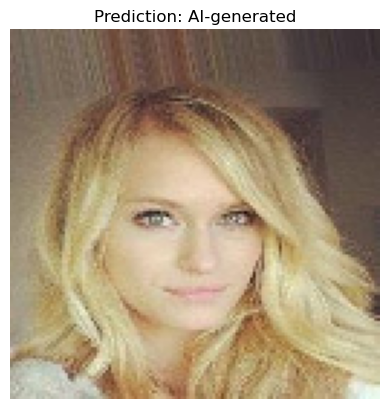

In [33]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('path_to_save_model/my_model.h5', compile=False)

# Function to preprocess the image and make predictions
def predict_image(image_path):
    # Load the image
    img = image.load_img(image_path, target_size=(128, 128))  # Resize the image to the required size

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand the dimensions to match the input format of the model (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image (if the model was trained with normalized data)
    img_array = img_array / 255.0

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to a binary outcome
    prediction_binary = (prediction > 0.5).astype(int)

    # Print the prediction
    if prediction_binary == 0:
        print("The image is classified as 'Class 0' (Real Image).")
    else:
        print("The image is classified as 'Class 1' (AI-generated Image).")

    # Show the image
    plt.imshow(img)
    plt.title(f"Prediction: {'Real' if prediction_binary == 0 else 'AI-generated'}")
    plt.axis('off')
    plt.show()

# Example usage
image_path =r"C:\Users\server4\Desktop\test\real\005391_preprocessed.jpg"  # Replace with the path to the image you want to classify
predict_image(image_path)


In [35]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io
import requests
from PIL import Image

# Load the trained models
cnn_model_filename = "cnn_model.h5"  # Replace with your CNN model path
inceptionv3_model_filename = "inceptionv3_model_trained.h5"  # Replace with your InceptionV3 model path

cnn_model = load_model(cnn_model_filename)
inceptionv3_model = load_model(inceptionv3_model_filename)

# Function to preprocess and predict on a single image
def predict_image(img, model_choice):
    # Check if the input is a URL, image file, or from webcam
    if isinstance(img, str):  # URL case
        img = Image.open(io.BytesIO(requests.get(img).content))
    elif isinstance(img, np.ndarray):  # Webcam or uploaded image case
        img = Image.fromarray(img)

    # Resize the image to match input size of the model
    img = img.resize((128, 128))

    # Convert the image to a numpy array and normalize
    img_array = np.array(img) / 255.0  # Normalize the pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Choose the appropriate model based on user selection
    if model_choice == "CNN Model":
        model = cnn_model
    elif model_choice == "InceptionV3 Model":
        model = inceptionv3_model

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to binary (0 for real, 1 for AI-generated)
    if prediction > 0.5:
        result = "AI-Generated"
    else:
        result = "Real"
    
    return img, result

# Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),  # Upload image
        gr.Dropdown(
            choices=["CNN Model", "InceptionV3 Model"],
            label="Select Model",
            value="CNN Model"
        )  # Dropdown to select model
    ],
    outputs=[
        gr.Image(type="pil", label="Predicted Image"), 
        gr.Textbox(label="Prediction Result")
    ],
    live=True
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Paths to the dataset
train_dir = r"C:/Users/91879/OneDrive/Desktop/train"
test_dir = r"C:/Users/91879/OneDrive/Desktop/Test"

# Load datasets
batch_size = 32
img_size = (128, 128)

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"  # Binary classification (Real vs AI-Generated)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

# Normalize the pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)

# Save the model
model_filename = "cnn_model_trained.h5"
model.save(model_filename)
print(f"Model saved as {model_filename}")


Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/10


C:\Users\91879\Downloads\DBMS-MINI-Project-master\New folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 226s 882ms/step - accuracy: 0.5050 - loss: 0.7346 - val_accuracy: 0.6010 - val_loss: 0.6738
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.6393 - loss: 0.6395 - val_accuracy: 0.6650 - val_loss: 0.6368
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 228s 878ms/step - accuracy: 0.8025 - loss: 0.4322 - val_accuracy: 0.5245 - val_loss: 2.9530
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 859ms/step - accuracy: 0.9529 - loss: 0.1285 - val_accuracy: 0.5280 - val_loss: 3.1724
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 827ms/step - accuracy: 0.9792 - loss: 0.0605 - val_accuracy: 0.5340 - val_loss: 3.5840
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 204s 814ms/step - accuracy: 0.9868 - loss: 0.0436 - val_accuracy: 0.5330 - val_loss: 4.7930
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 209s 832ms/step - accuracy: 0.9924 - loss: 0.0238 - val_accuracy: 0.5290 - val_loss: 5.2206
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 212s 843ms/step - accuracy: 0.9943 - loss: 0.0190 

Model saved as cnn_model_trained.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Prediction: Real


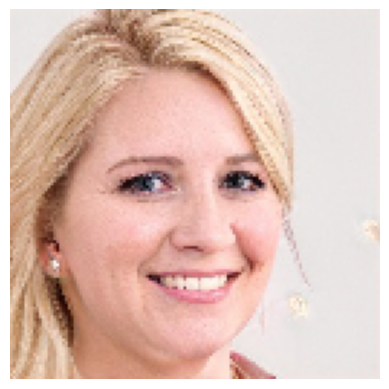

In [8]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("cnn_model_trained.h5")

# Function to preprocess and predict on a single image
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    result = "AI-Generated" if prediction > 0.5 else "Real"
    
    return result, img

test_image_path = r"C:\Users\91879\OneDrive\Desktop\Test\ai\4JSRICVB89.jpg"  # Replace with your test image path


# Predict and display the result
result, img = predict_image(test_image_path)
print(f"Prediction: {result}")
plt.imshow(img)
plt.axis('off')
plt.show()


In [9]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained CNN model
model_filename = "cnn_model_trained.h5"  # Replace with the correct path to your saved model
model = load_model(model_filename)

# Function to preprocess and predict an image
def predict_image(img):
    # Resize the image to match input size of the model
    img = img.resize((128, 128))  # Ensure it matches the model's input size
    
    # Convert the image to a numpy array and normalize
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to binary (0 for real, 1 for AI-generated)
    if prediction > 0.5:
        result = "AI-Generated"
    else:
        result = "Real"

    return result

# Gradio Interface
iface = gr.Interface(
    fn=predict_image,  # Function to be called
    inputs=gr.Image(type="pil", label="Upload Image"),  # Input image
    outputs=gr.Textbox(label="Prediction Result"),  # Display result
    title="Real or AI-Generated Image Detector",
    description="Upload an image to classify it as Real or AI-Generated using a CNN model.",
)

# Launch the Gradio app
iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
